In [1]:
%matplotlib inline

import skimage.color
import skimage.io
import skimage.filters
import skimage.feature
import skimage.exposure

import numpy
import matplotlib.pyplot as plt
import math

## Input image

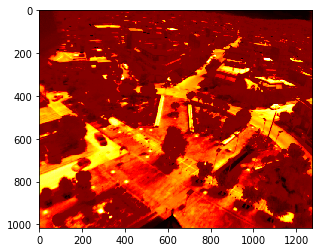

In [2]:
raw = skimage.io.imread("AthenIR.png")
gray = skimage.color.rgb2gray(raw)
plt.imshow(gray, cmap='hot')

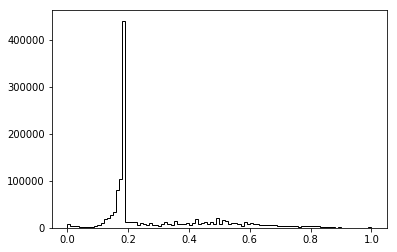

In [3]:
plt.hist(gray.ravel(), bins=100, histtype='step', color='black');

The image has a very unevently distributed histogram, so we perform histogram equalization to improve contrast.

/usr/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


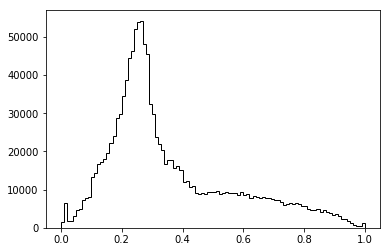

In [4]:
img = skimage.exposure.equalize_adapthist(gray, clip_limit=0.015)
#r = (numpy.percentile(gray, 20), numpy.percentile(gray, 80))
#img = skimage.exposure.rescale_intensity(gray, in_range=r)
plt.hist(img.ravel(), bins=100, histtype='step', color='black');

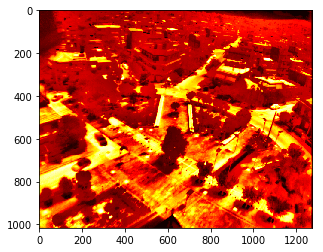

In [5]:
plt.imshow(img, cmap='hot')

## Edge detect operators

In [35]:
def convolve_kernel(image, kernel):
    if kernel.shape != (3, 3):
        raise ValueError("Kernel must have shape 3x3")
    
    out = numpy.ndarray(shape=image.shape, dtype=image.dtype)
    height, width = image.shape
    
    for x in range(0, width):
        for y in range(0, height):
            new_value = 0.0
            for kx in range(0, kernel.shape[1]):
                for ky in range(0, kernel.shape[0]):
                    # if trying to access outside image, instead use closest value
                    sx = min(max(x+kx-1, 0), width-1)
                    sy = min(max(y+ky-1, 0), height-1)
                    #sx = x+kx-1
                    #sy = y+ky-1
                    k = kernel[ky][kx]
                    s = image[sy][sx]
                    new_value += (s * k)
                    #print((x, y), (sx, sy), k, new_value)
            out[y][x] = new_value
    return out

In [36]:
kernels = {
    'prewitt_x': numpy.array((
        (-1, 0, 1),
        (-1, 0, 1),
        (-1, 0, 1),
     )) / 3.0,
    'prewitt_y': numpy.array((
        (-1, -1, -1),
        (0, 0, 0),
        (1, 1, 1),
     )) / 3.0,
    'sobel_x': numpy.array((
        (-1, 0, 1),
        (-2, 0, 2),
        (-1, 0, 1),
     )) / 4.0,
    'sobel_y': numpy.array((
        (-1, -2, -1),
        (0, 0, 0),
        (1, 2, 1),
     )) / 4.0,
    'goodsobel_x': numpy.array((
        (-3, 0, 3),
        (-10, 0, 10),
        (-3, 0, 3),
     )) / 16.0,
    'goodsobel_y': numpy.array((
        (-3, -10, -3),
        (0, 0, 0),
        (3, 10, 3),
     )) / 16.0,
    'boxblur': numpy.array((
        (1, 1, 1),
        (1, 1, 1),
        (1, 1, 1),
     )) / 9.0,
    'laplacian4': numpy.array((
        (0, 1, 0),
        (1, -4, 1),
        (0, 1, 0),
     )) / 4.0,
    'laplacian12': numpy.array((
        (1, 2, 1),
        (2, -12, 2),
        (1, 2, 1),
     )) / 12.0,
}

In [37]:
def edge_operator(image, operator):
    """Returns the reusult from one of the edge operators, prewitt, sobel,
    canny eller laplace"""
    
    if operator in ('sobel', 'prewitt', 'goodsobel'):
        # Get edges in X,T separately
        kernel_x = kernels['{}_x'.format(operator)]
        kernel_y = kernels['{}_y'.format(operator)]
        x = convolve_kernel(image, kernel_x)
        y = convolve_kernel(image, kernel_y)
        # Calculate edge magnitude
        return numpy.sqrt(x**2 + y**2)
    
    elif operator == 'laplacian':
        k = kernels['laplacian12']
        #l = numpy.abs(convolve_kernel(image, k))
        l = convolve_kernel(image, k)
        return l
    
    # Using skimage implementations as references
    elif operator == 'sobelref':
        return skimage.filters.sobel(image)
    elif operator == 'laplacian size11':
        return skimage.filters.laplace(image, ksize=11)
    
    elif operator == 'canny':
        # Smooths image with Gaussian filter
        # Calculates x/y gradient vector and local gradient magnitude/orientation
        # Isolate local maxima of gradient magnitude using 'non-maximum supression' along local gradient direction
        # Collects sets of connected edge pixels from local maxima using hysteresis threshold
        return skimage.feature.canny(image, sigma=1.2)
    else:
        raise ValueError('Unknown operator {}'.format(operator))


## Comparison of edge detect operators

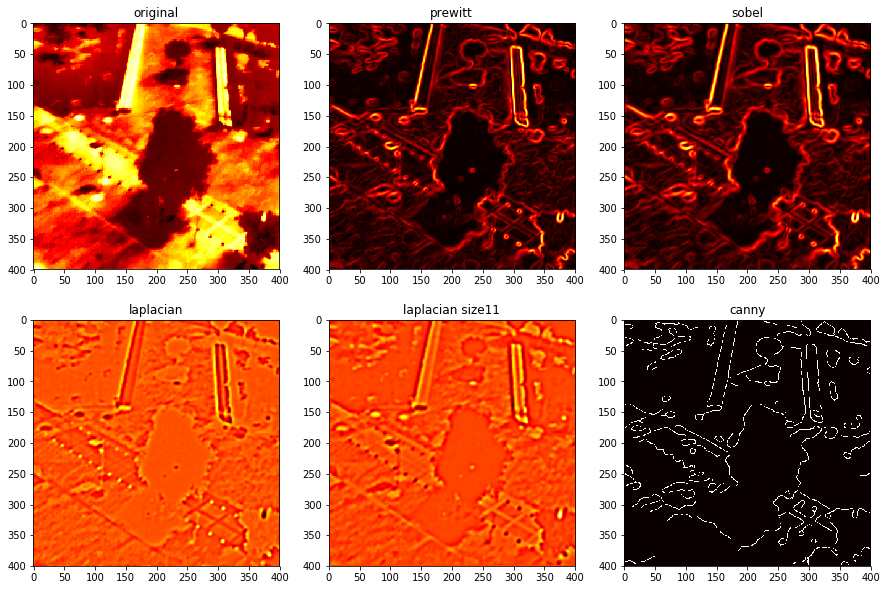

In [38]:
def plot_method_comparison(img):

    methods = ('original', 'prewitt', 'sobel', 'laplacian', 'laplacian size11', 'canny')
    figure, plots = plt.subplots(2, math.ceil(len(methods)/2), figsize=(15, 10))
    plots = plots.flatten()
    
    for method, ax in zip(methods, plots):
        if method == 'original':
            out = img
        else:
            img = skimage.filters.gaussian(img, 1.2)
            out = edge_operator(img, method)
            threshold = skimage.filters.threshold_otsu(out)
            #out = out <= threshold
        ax.set_title(method)
        ax.imshow(out, cmap='hot')

    return figure

plot_method_comparison(img[400:800, 400:800]);

The Prewitt and Sobel filters give nearly indistinguishable results.
The Canny feature detector performs a robust adaptive edge grouping in addition to edge detection, and looks to give the best results in terms of feature segmentation.

## Image sharpening methods

In [39]:
def sharpen(image, method, strength=0.5, gamma=5, preblur=0):
    """Performs an image sharpening using Laplace filter or unsharpen mask (USM)
    Returns: sharpened image
    """
    
    if method == 'laplacian':
        # Laplace sharpening done by applying Laplacian filter,
        # then from image subtracting a fraction of it
        if preblur:
            image = skimage.filters.gaussian(image, preblur)
        laplaced = convolve_kernel(image, kernels['laplacian12'])
        sharpened = image - (strength * laplaced)
        return sharpened
    elif method == 'usm':
        # Unsharpen-mask
        smooth = skimage.filters.gaussian(image, gamma)
        mask = image - (strength * smooth)
        sharpened = image + mask
        return sharpened
    else:
        raise ValueError('Unknown sharpening method {}'.format(method))    

## Comparison of image sharpening

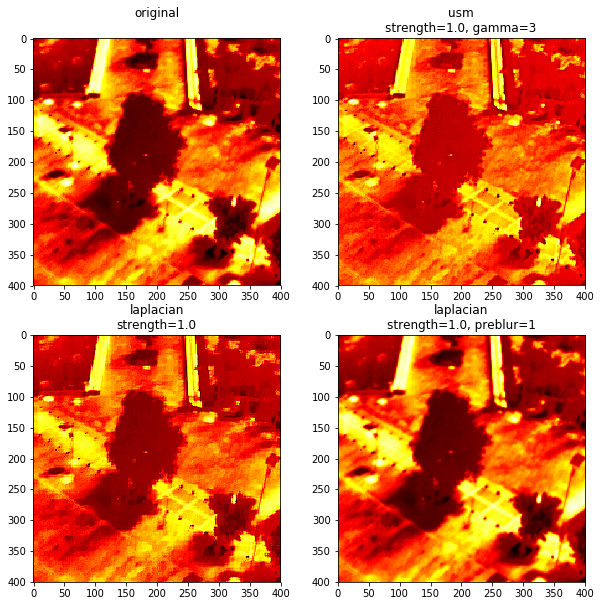

In [41]:
def plot_sharpen_methods(img):
    strength = 1.0 
    experiments = [
        ('original', {}),
        ('usm', dict(strength=strength, gamma=3)),
        ('laplacian', {'strength': strength}),
        ('laplacian', dict(strength=strength, preblur=1)),
    ]
    rows = 2
    figure, plots = plt.subplots(rows, math.ceil(len(experiments)/rows), figsize=(10, 10))
    plots = plots.flatten()
    
    for ex, ax in zip(experiments, plots):
        method, params = ex
        if method == 'original':
            out = img
        else:
            out = sharpen(img, method, **params)
            
        #out = img - out
            
        ax.set_title("{}\n{}".format(method, ', '.join("{}={}".format(k,v) for k,v in params.items())))
        ax.imshow(out, cmap='hot')

    return figure

plot_sharpen_methods(img[450:850, 450:850]);

USM gives sharper details, see centerline of benches on top and the diagonal sidewalk, without introducing much noise.

The Laplacian introduces a bit of fine-textured noise across the whole image, and has still has less distinct edges than USM.  

When applying a gaussian blur prior to Laplacian the noise goes away, but smaller features start to disappear, giving no improvement over the original image.